# Task Scheduler Simulation Analysis

Analyzes the output of the task scheduler simulations, comparing different scheduling algorithms across various metrics.

In [ ]:
import json
import re
from pathlib import Path
from typing import Dict, List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

RESULTS_DIR = Path("../output/results")

In [2]:
def parse_filename(filename: str) -> Dict[str, str]:
    """Parse filename to extract task count, workload type, policy, and stats type."""
    # Pattern: tasks_{count}_{type}_{policy}_{stats_type}.json
    pattern = r"tasks_(\d+)_(\w+)_(\w+)_(task_stats|machine_stats)\.json"
    match = re.match(pattern, filename)
    if match:
        return {
            "task_count": int(match.group(1)),
            "workload_type": match.group(2),
            "policy": match.group(3),
            "stats_type": match.group(4)
        }
    return None

def load_all_results() -> tuple[pd.DataFrame, pd.DataFrame]:
    """Load all task stats and machine stats from the results directory."""
    task_stats_list = []
    machine_stats_list = []
    
    for file_path in RESULTS_DIR.glob("*.json"):
        parsed = parse_filename(file_path.name)
        if not parsed:
            continue
            
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        if parsed["stats_type"] == "task_stats":
            # Extract summary data
            task_stats_list.append({
                "task_count": parsed["task_count"],
                "workload_type": parsed["workload_type"],
                "policy": parsed["policy"],
                "makespan": data["makespan"],
                "simulation_clock": data["simulationClock"],
                "total_tasks": data["totalTasks"],
                "tasks": data["tasks"]
            })
        else:  # machine_stats
            machine_stats_list.append({
                "task_count": parsed["task_count"],
                "workload_type": parsed["workload_type"],
                "policy": parsed["policy"],
                "vm_count": data["vmCount"],
                "avg_cluster_cpu": data["avgClusterCpuPercent"],
                "avg_cluster_ram": data["avgClusterRamPercent"],
                "vms": data["vms"]
            })
    
    return task_stats_list, machine_stats_list

task_stats_raw, machine_stats_raw = load_all_results()
print(f"Loaded {len(task_stats_raw)} task stats files and {len(machine_stats_raw)} machine stats files")


Loaded 36 task stats files and 36 machine stats files


In [10]:
def process_task_stats(raw_data: List[Dict]) -> pd.DataFrame:
    """Process raw task stats into a summary DataFrame with computed metrics."""
    records = []
    for entry in raw_data:
        tasks = entry["tasks"]
        exec_times = [t["execTime"] for t in tasks]
        
        records.append({
            "task_count": entry["task_count"],
            "workload_type": entry["workload_type"],
            "policy": entry["policy"],
            "makespan": entry["makespan"],
            "avg_exec_time": np.mean(exec_times),
            "median_exec_time": np.median(exec_times),
            "std_exec_time": np.std(exec_times),
            "min_exec_time": np.min(exec_times),
            "max_exec_time": np.max(exec_times),
        })
    
    return pd.DataFrame(records)

def process_machine_stats(raw_data: List[Dict]) -> pd.DataFrame:
    """Process raw machine stats into a summary DataFrame with computed metrics."""
    records = []
    for entry in raw_data:
        vms = entry["vms"]
        
        avg_cpus = [vm["avgCpuPercent"] for vm in vms]
        peak_cpus = [vm["peakCpuPercent"] for vm in vms]
        avg_rams = [vm["avgRamPercent"] for vm in vms]
        peak_rams = [vm["peakRamPercent"] for vm in vms]
        task_counts = [vm["taskCount"] for vm in vms]
        
        records.append({
            "task_count": entry["task_count"],
            "workload_type": entry["workload_type"],
            "policy": entry["policy"],
            "avg_cluster_cpu": entry["avg_cluster_cpu"],
            "avg_cluster_ram": entry["avg_cluster_ram"],
            "avg_peak_cpu": np.mean(peak_cpus),
            "avg_peak_ram": np.mean(peak_rams),
            "cpu_var": np.var(avg_cpus),
            "ram_var": np.var(avg_rams),
            "cpu_std": np.std(avg_cpus),
            "ram_std": np.std(avg_rams),
            "task_distribution_std": np.std(task_counts),  # How evenly tasks are distributed
        })
    
    return pd.DataFrame(records)

# Create processed DataFrames
df_tasks = process_task_stats(task_stats_raw)
df_machines = process_machine_stats(machine_stats_raw)

# Merge for combined analysis
df_combined = pd.merge(df_tasks, df_machines, on=["task_count", "workload_type", "policy"])

# print("Task Stats Summary:")
# display(df_tasks.head())
# print("\nMachine Stats Summary:")
# display(df_machines.head())

In [13]:
# Helper function to determine if we should zoom in on y-axis
def should_zoom_axis(values: List[float], threshold: float = 0.15) -> tuple[bool, float, float]:
    """
    Determine if y-axis should be zoomed to highlight differences.
    Returns (should_zoom, y_min, y_max) where y_min/y_max are suggested limits.
    Zooms in when the range is less than threshold * mean (i.e., values are close together).
    """
    if len(values) < 2 or all(v == 0 for v in values):
        return False, 0, max(values) * 1.1 if values else 1
    
    min_val, max_val = min(values), max(values)
    mean_val = np.mean(values)
    value_range = max_val - min_val
    
    # If range is small relative to mean, zoom in
    if mean_val > 0 and value_range / mean_val < threshold:
        padding = value_range * 0.5 if value_range > 0 else mean_val * 0.1
        y_min = max(0, min_val - padding)
        y_max = max_val + padding
        return True, y_min, y_max
    
    return False, 0, max_val * 1.1

POLICY_ORDER = ["RoundRobinCloudletVmPolicy", "WeightedResourcePolicy", "SortedTaskBestFitPolicy"]

def get_policy_color(policy: str) -> str:
    color_map = {
        "RoundRobinCloudletVmPolicy": "#66A61E",
        "WeightedResourcePolicy": "#1F78B4",
        "SortedTaskBestFitPolicy": "#E31A1C"
    }
    return color_map.get(policy, "blue")

def get_policy_label(policy: str) -> str:
    label_map = {
        "RoundRobinCloudletVmPolicy": "Round Robin",
        "WeightedResourcePolicy": "Weighted Resource",
        "SortedTaskBestFitPolicy": "SortedTaskBestFit"
    }
    return label_map.get(policy, "WeightedResourcePolicy")

# Helper function for creating comparison bar charts
def plot_metric_comparison(df: pd.DataFrame, metric: str, title: str, ylabel: str, 
                           workload_type: str = None, task_count: int = None):
    """Create a bar chart comparing algorithms for a specific metric."""
    # Filter data if specific workload/task_count provided
    data = df.copy()
    subtitle_parts = []
    
    if workload_type:
        data = data[data["workload_type"] == workload_type]
        subtitle_parts.append(f"Workload: {workload_type}")
    if task_count:
        data = data[data["task_count"] == task_count]
        subtitle_parts.append(f"Tasks: {task_count}")
    
    subtitle = " | ".join(subtitle_parts) if subtitle_parts else "All data"
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    policies = [p for p in POLICY_ORDER if p in data["policy"].values]
    x = np.arange(len(policies))
    width = 0.8
    
    values = [data[data["policy"] == p][metric].mean() for p in policies]
    colors = [get_policy_color(p) for p in policies]
    bars = ax.bar(x, values, width, color=colors)
    
    # Adjust y-axis if values are large but close together
    zoom, y_min, y_max = should_zoom_axis(values)
    if zoom:
        ax.set_ylim(y_min, y_max)
        subtitle += " | Y-axis scaled"
    
    ax.set_ylabel(ylabel)
    ax.set_title(f"{title}\n({subtitle})")
    ax.set_xticks(x)
    ax.set_xticklabels([get_policy_label(p) for p in policies])
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        ax.annotate(f'{val:.2f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    return fig

def plot_grouped_bars(df: pd.DataFrame, metric: str, title: str, ylabel: str, 
                      group_by: str = "workload_type"):
    """Create grouped bar chart comparing algorithms across workload types or task counts."""
    fig, ax = plt.subplots(figsize=(14, 7))
    
    groups = sorted(df[group_by].unique()) if group_by == "task_count" else df[group_by].unique()
    policies = [p for p in POLICY_ORDER if p in df["policy"].values]
    
    x = np.arange(len(groups))
    width = 0.25
    multiplier = 0
    
    all_values = []
    for policy in policies:
        policy_data = df[df["policy"] == policy]
        values = [policy_data[policy_data[group_by] == g][metric].mean() for g in groups]
        all_values.extend(values)
        offset = width * multiplier
        ax.bar(x + offset, values, width, 
               label=get_policy_label(policy), 
               color=get_policy_color(policy))
        multiplier += 1
    
    # Adjust y-axis if values are large but close together
    zoom, y_min, y_max = should_zoom_axis(all_values)
    if zoom:
        ax.set_ylim(y_min, y_max)
        title += "\n(Y-axis scaled to highlight differences)"
    
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x + width)
    ax.set_xticklabels(groups)
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    
    plt.tight_layout()
    return fig

def plot_line_by_task_count(df: pd.DataFrame, metric: str, title: str, ylabel: str, 
                            workload_type: str = None):
    """Create line chart showing metric vs task count for each algorithm."""
    data = df.copy()
    if workload_type:
        data = data[data["workload_type"] == workload_type]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    policies = [p for p in POLICY_ORDER if p in data["policy"].values]
    
    all_values = []
    for policy in policies:
        policy_data = data[data["policy"] == policy].sort_values("task_count")
        values = policy_data[metric].tolist()
        all_values.extend(values)
        ax.plot(policy_data["task_count"], policy_data[metric], 
                marker='o', linewidth=2, markersize=8, 
                color=get_policy_color(policy),
                label=get_policy_label(policy))
    
    # Adjust y-axis if values are large but close together
    zoom, y_min, y_max = should_zoom_axis(all_values)
    if zoom:
        ax.set_ylim(y_min, y_max)
        title += "\n(Y-axis scaled to highlight differences)"
    
    ax.set_xlabel("Number of Tasks")
    ax.set_ylabel(ylabel)
    subtitle = f"Workload: {workload_type}" if workload_type else "All workloads averaged"
    ax.set_title(f"{title}\n({subtitle})")
    ax.legend()
    ax.set_xticks(sorted(data["task_count"].unique()))
    
    plt.tight_layout()
    return fig

## 1. Average and Median Cloudlet Execution Time by Algorithm

Comparing how long tasks take to complete on average across different scheduling algorithms.

In [8]:
workload_types = df_tasks["workload_type"].unique()
task_counts = sorted(df_tasks["task_count"].unique())

print(f"Workload types: {workload_types}")
print(f"Task counts: {task_counts}")

Workload types: ['balanced' 'cpu_heavy' 'ram_heavy']
Task counts: [200, 1000, 3000, 5000]


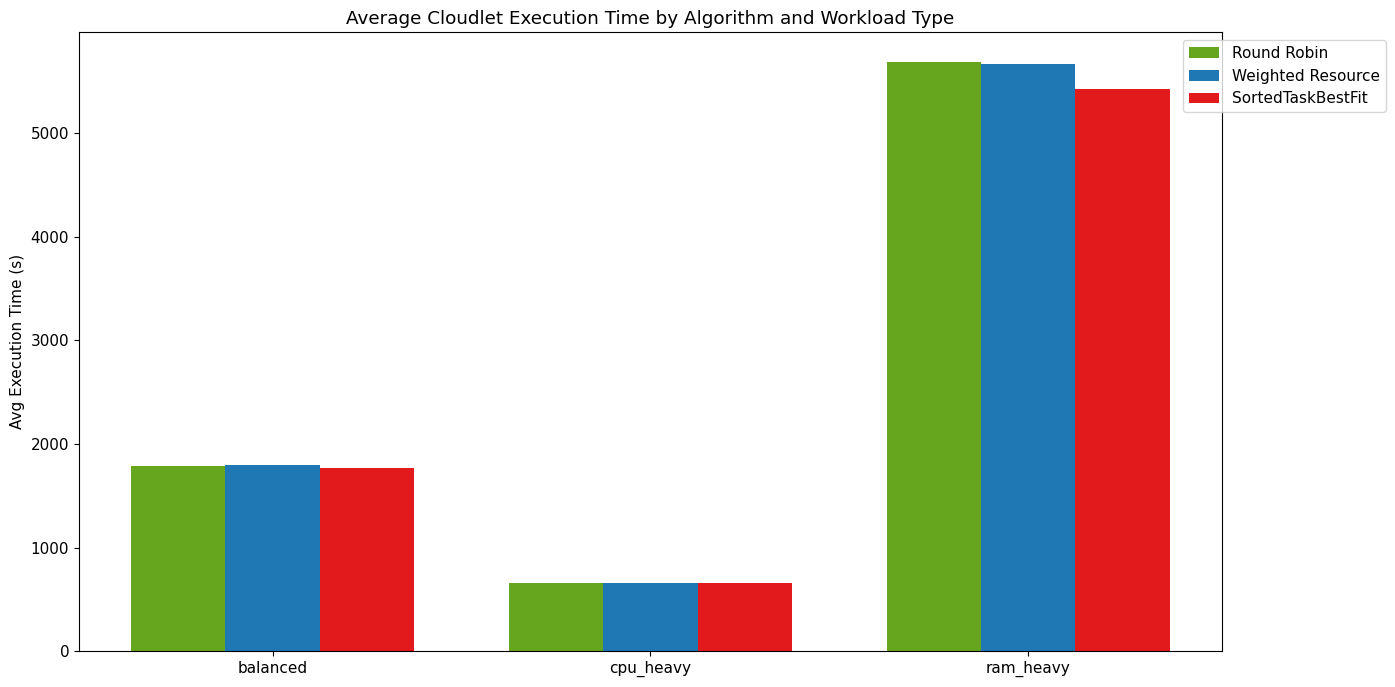

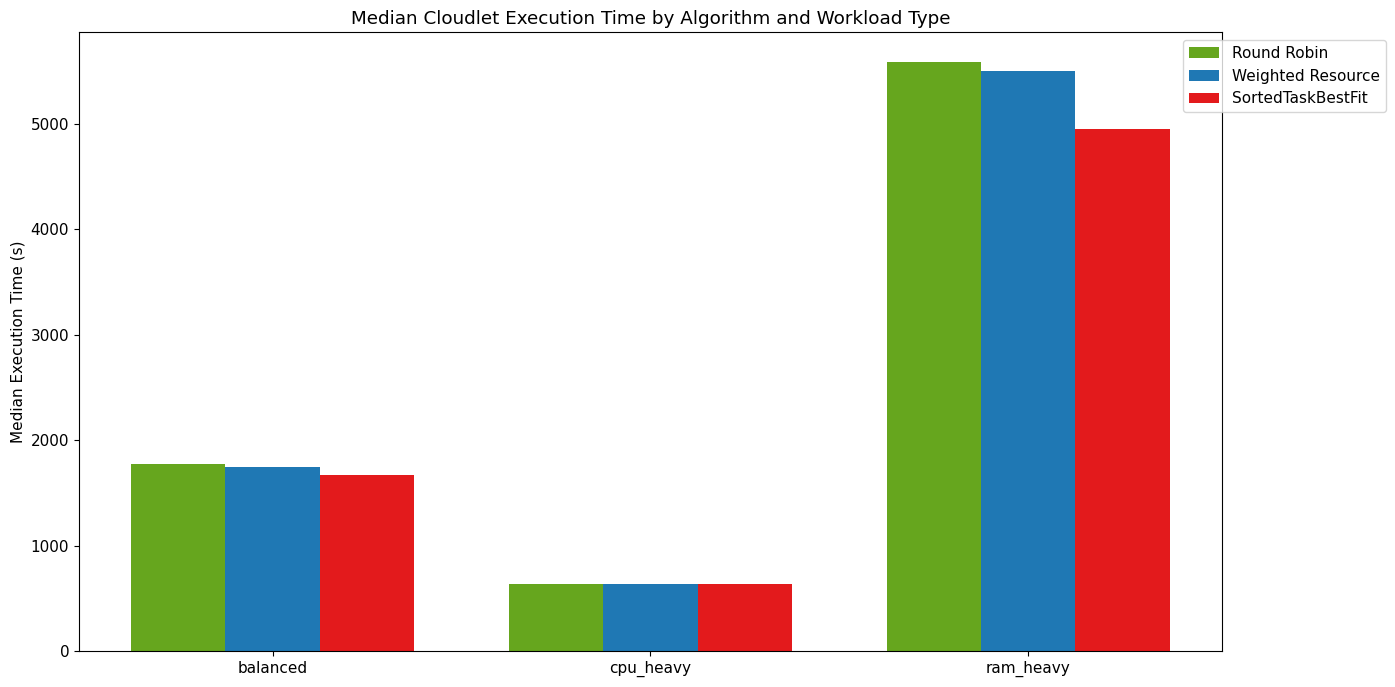

In [15]:
# Average Execution Time - Grouped by workload type (all task counts)
plot_grouped_bars(df_tasks, "avg_exec_time", 
                  "Average Cloudlet Execution Time by Algorithm and Workload Type",
                  "Avg Execution Time (s)", group_by="workload_type")
plt.show()

# Median Execution Time - Grouped by workload type
plot_grouped_bars(df_tasks, "median_exec_time", 
                  "Median Cloudlet Execution Time by Algorithm and Workload Type",
                  "Median Execution Time (s)", group_by="workload_type")
plt.show()

## 2. Average CPU Utilization by Algorithm

How efficiently each algorithm uses CPU resources across the cluster.

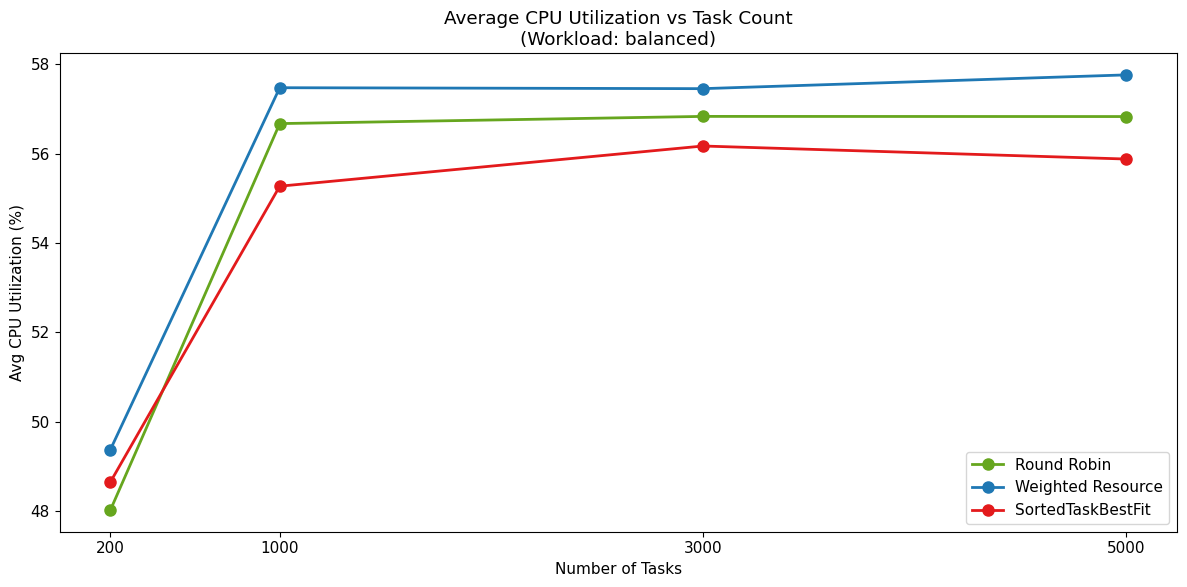

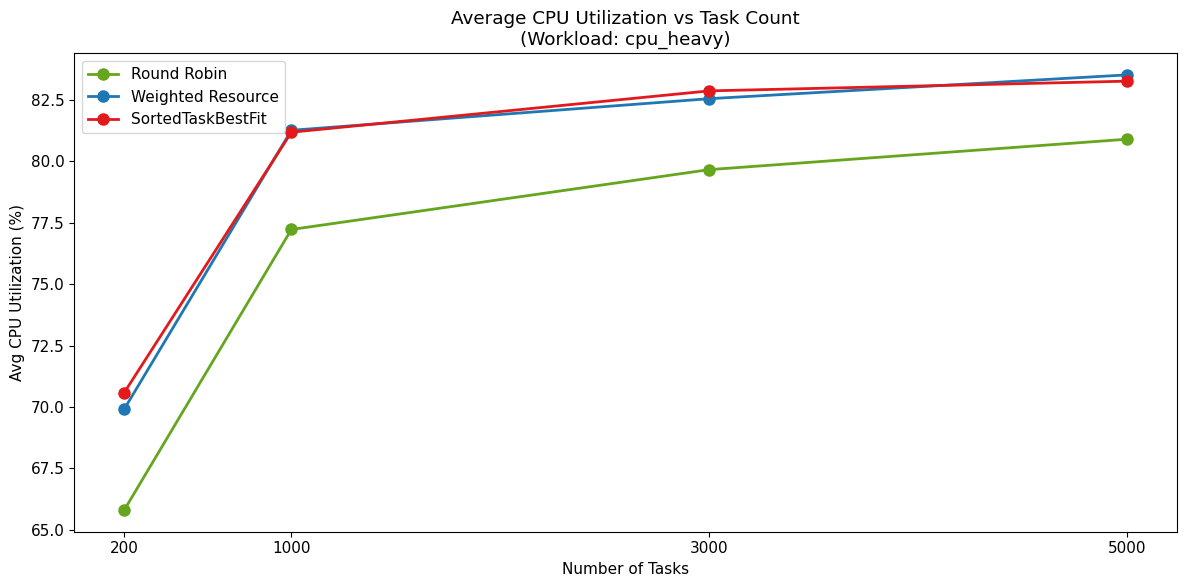

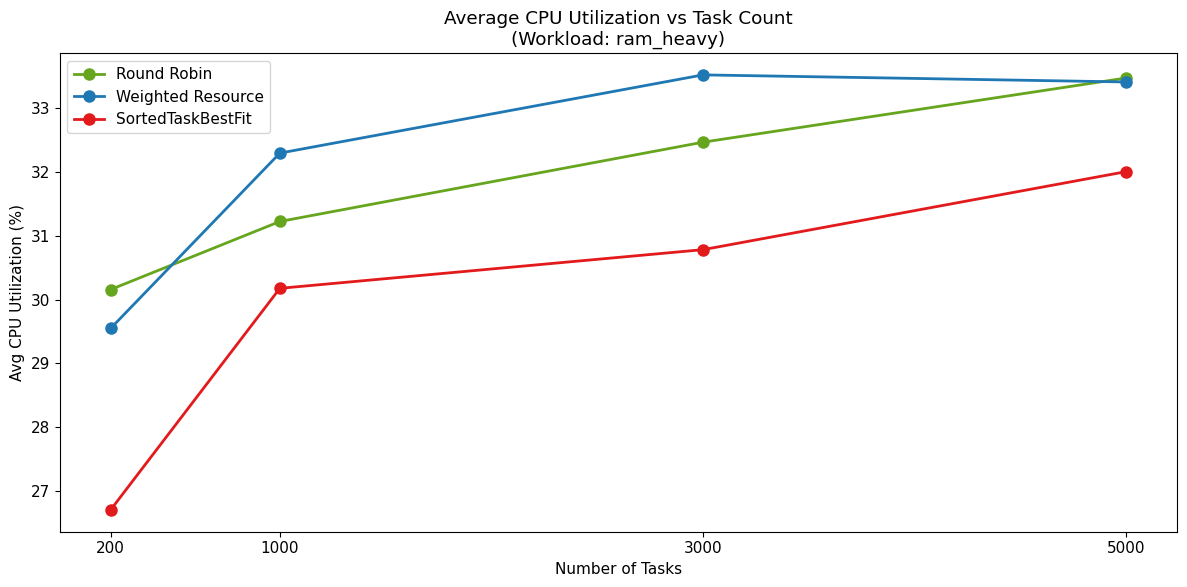

In [16]:
# Line chart - CPU vs task count per workload
for wt in workload_types:
    plot_line_by_task_count(df_machines, "avg_cluster_cpu",
                            "Average CPU Utilization vs Task Count",
                            "Avg CPU Utilization (%)", workload_type=wt)
    plt.show()

## 3. Resource Utilization Standard Deviation Between Machines by Algorithm

How evenly load is distributed across VMs - lower variance means better load balancing.

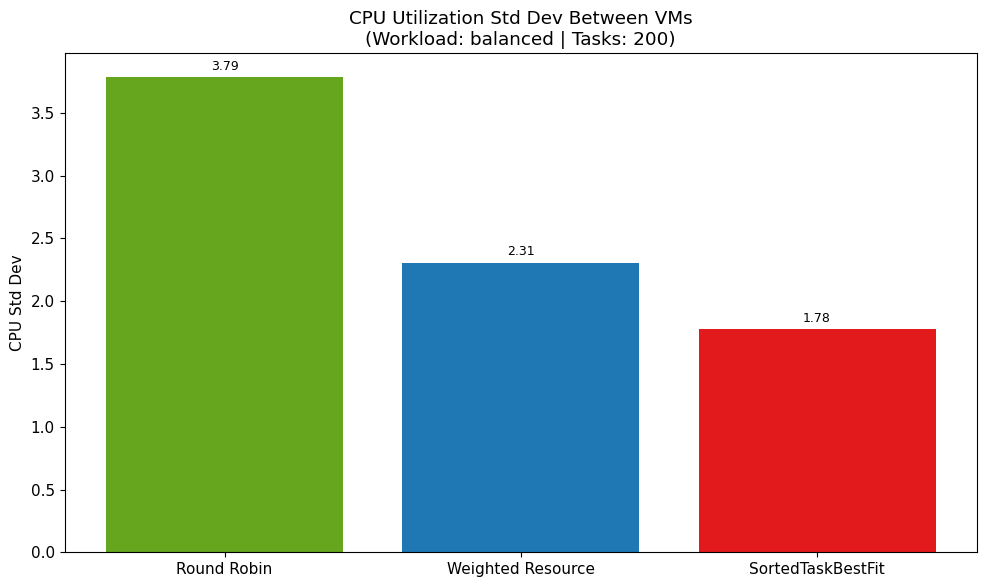

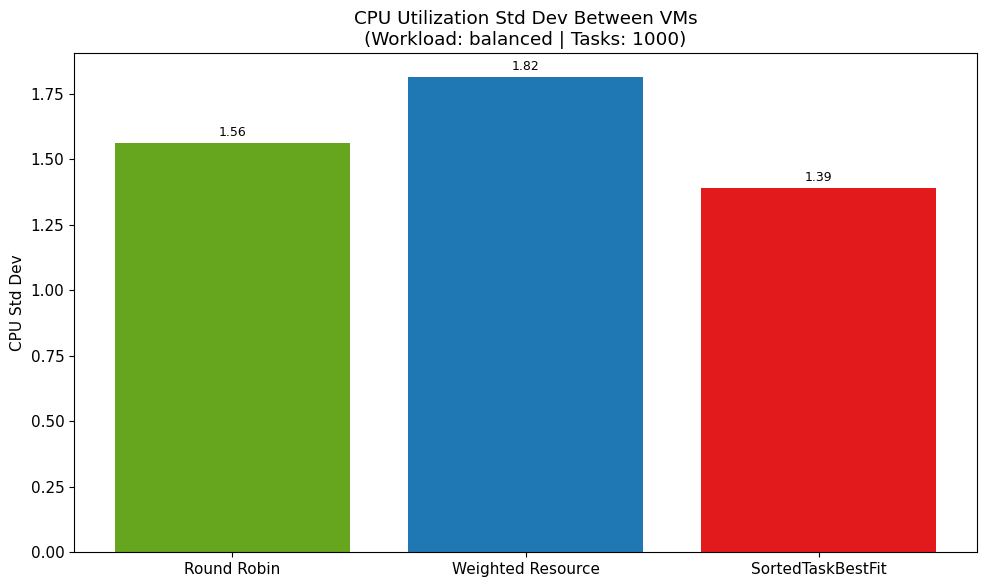

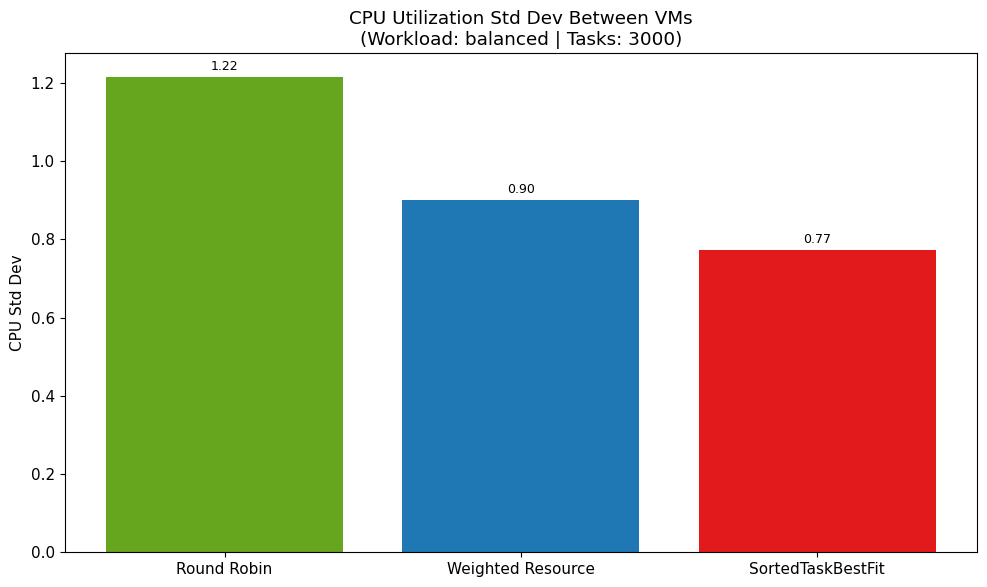

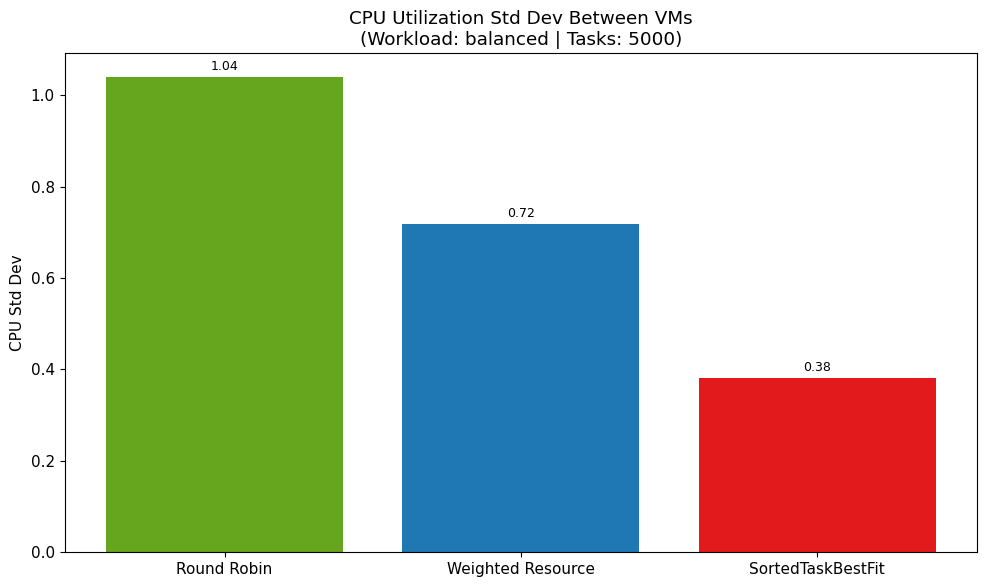

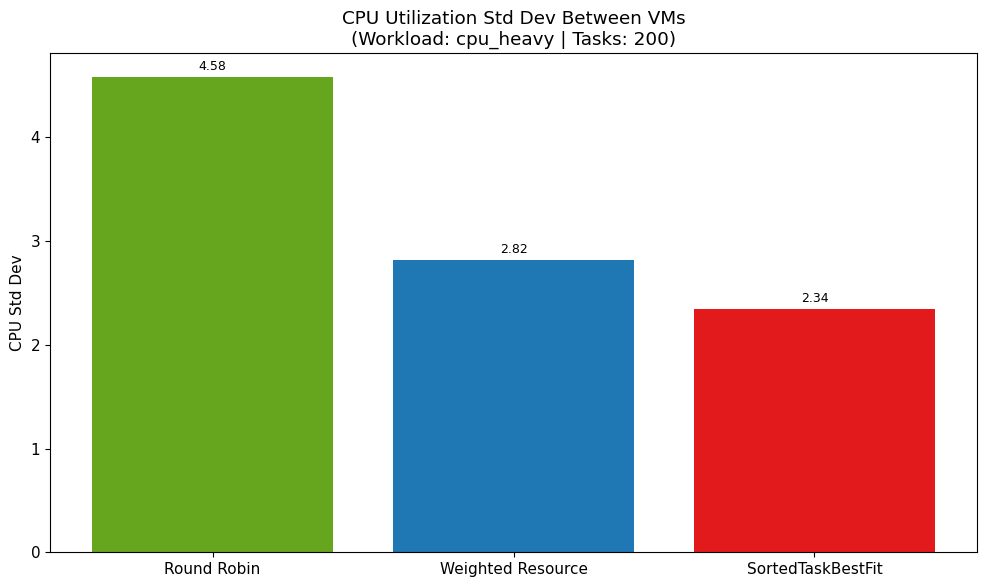

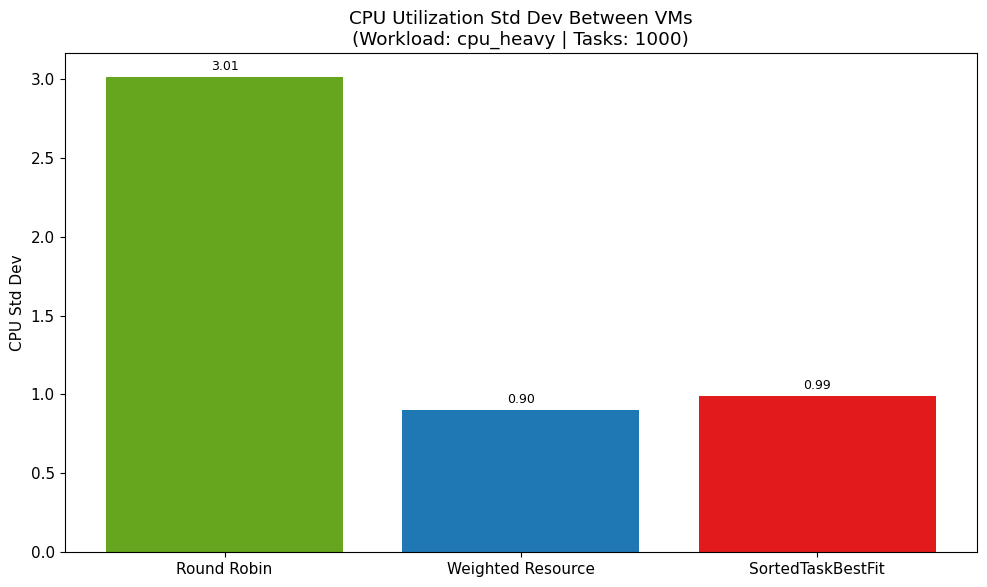

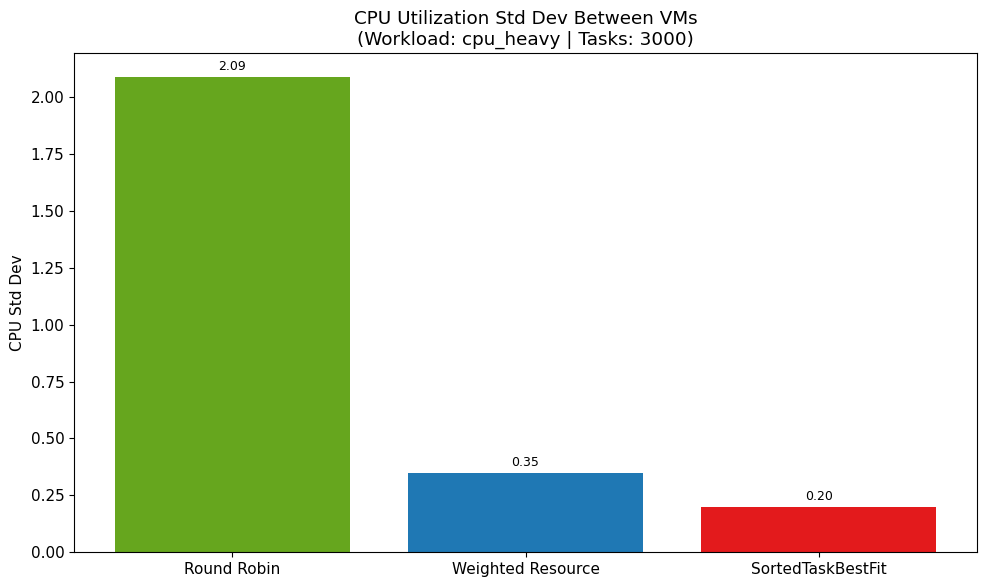

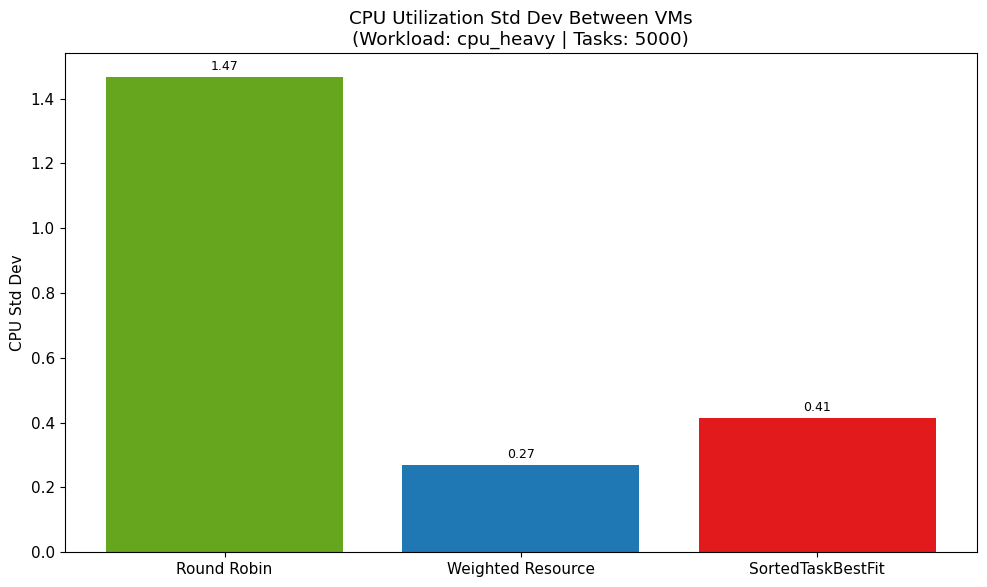

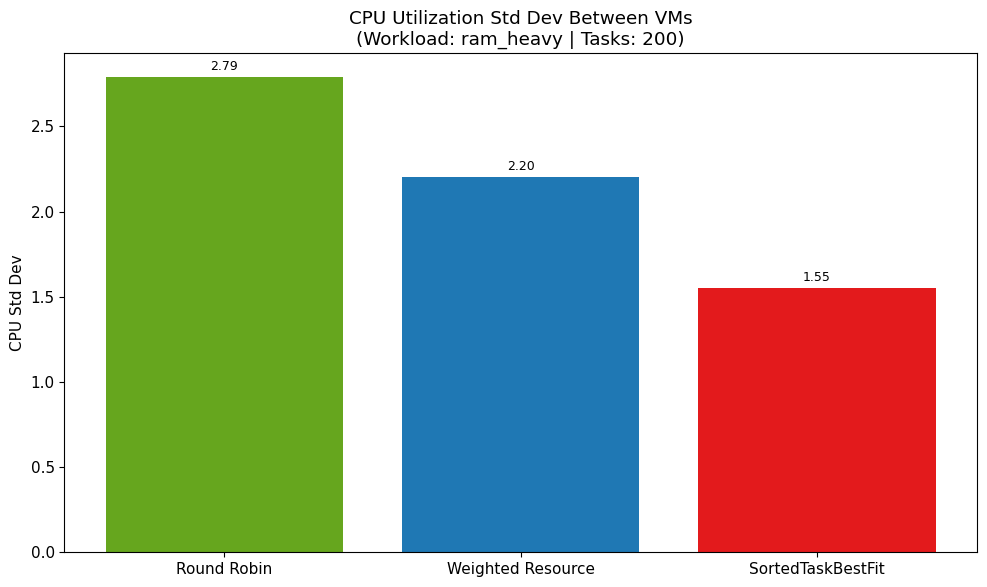

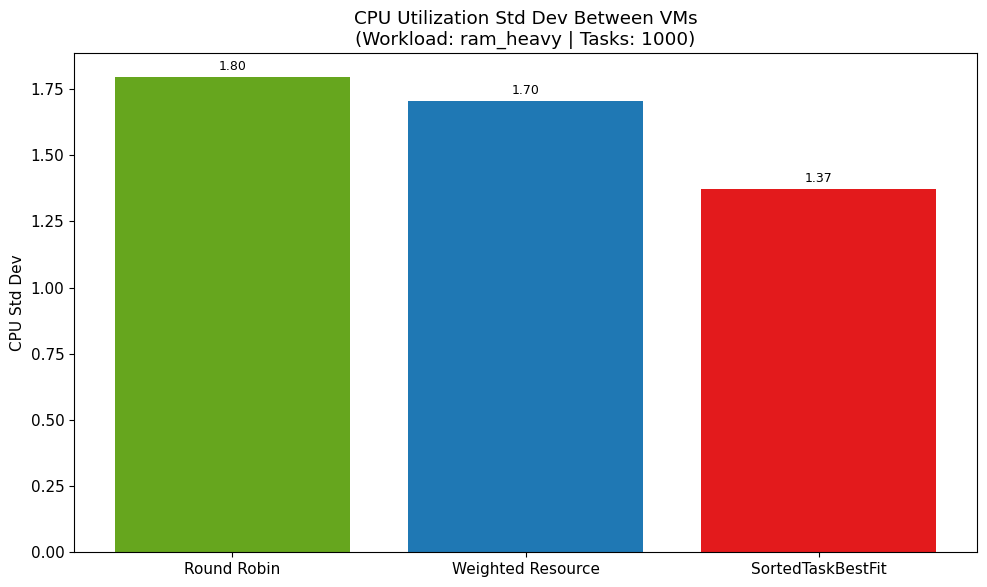

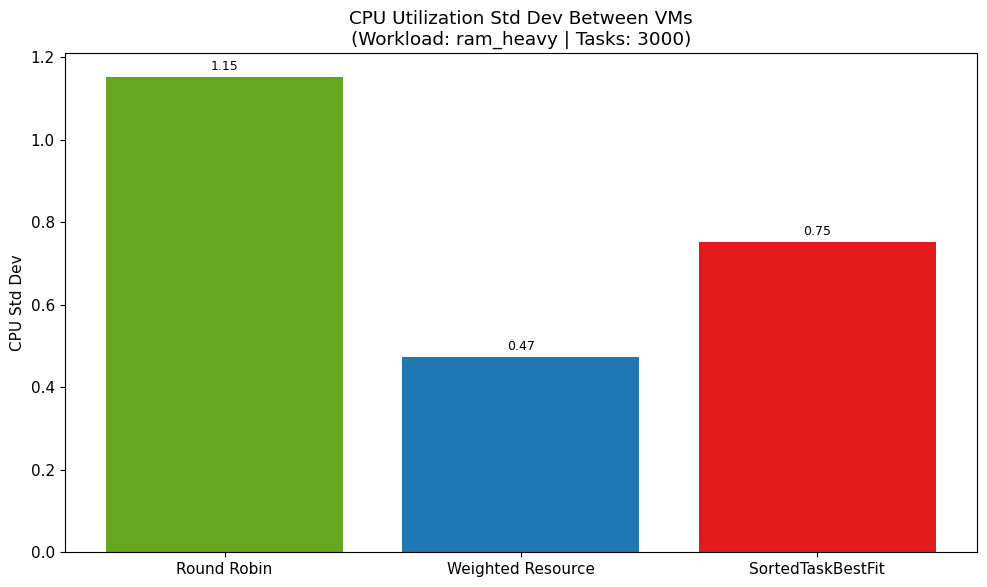

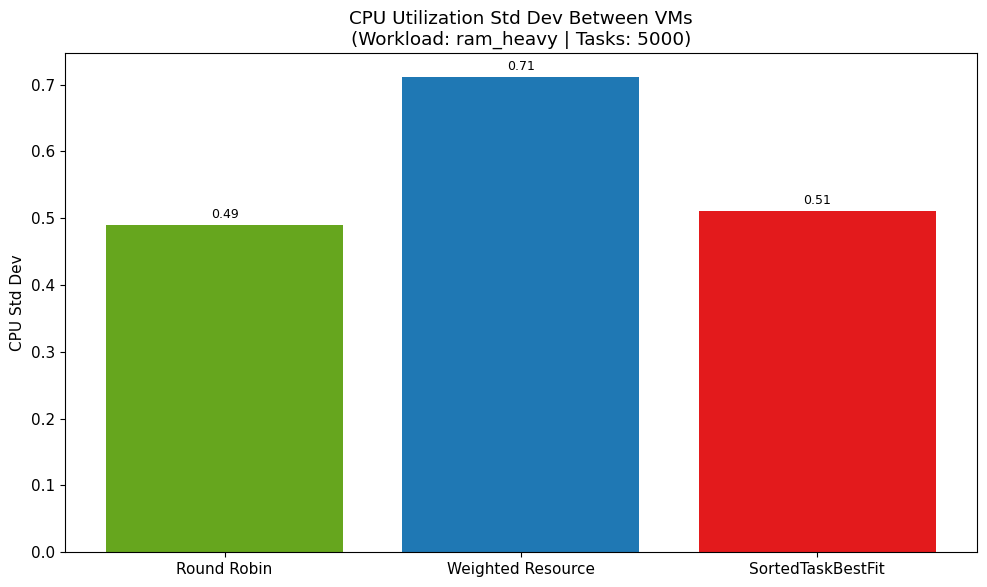

In [19]:
# CPU Std Dev - Per workload type, per task count
for wt in workload_types:
    for tc in task_counts:
        plot_metric_comparison(df_machines, "cpu_std", 
                               "CPU Utilization Std Dev Between VMs",
                               "CPU Std Dev", workload_type=wt, task_count=tc)
        plt.show()

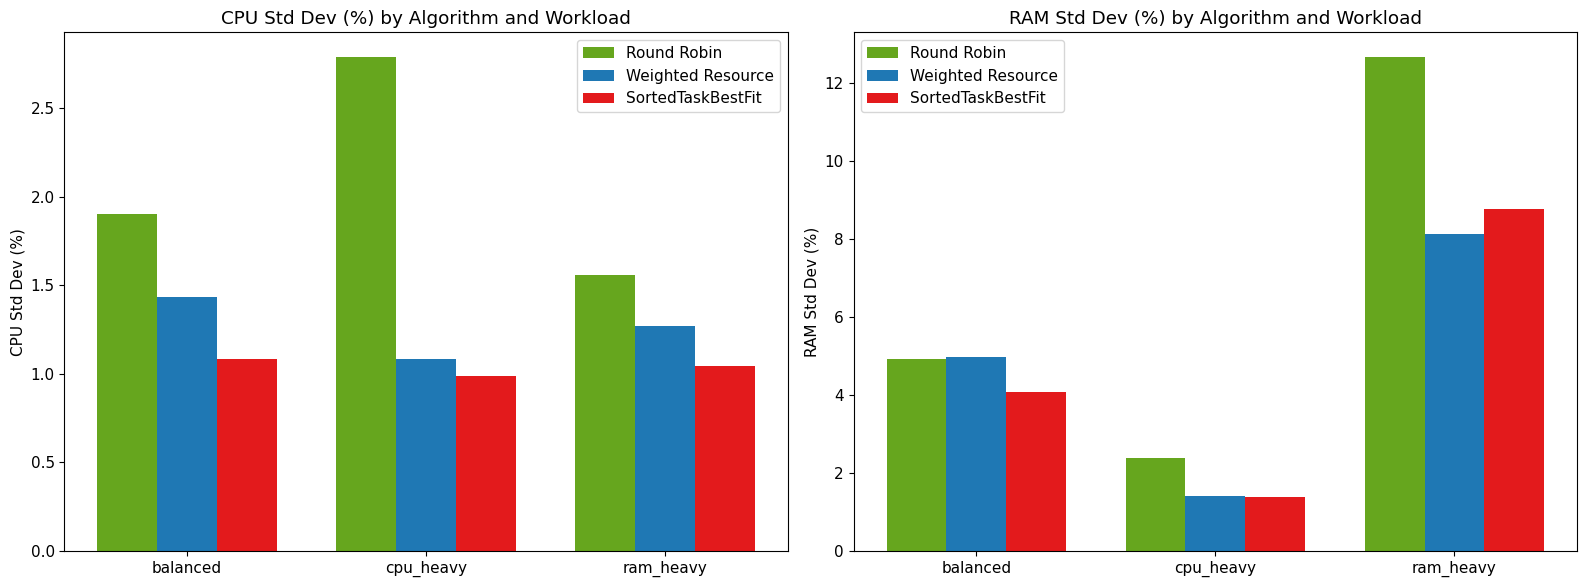

In [20]:
# 7.5 Combined CPU/RAM Standard Deviation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (metric, label) in enumerate([("cpu_std", "CPU Std Dev (%)"), ("ram_std", "RAM Std Dev (%)")]):
    ax = axes[idx]
    policies = [p for p in POLICY_ORDER if p in df_machines["policy"].values]
    x = np.arange(len(workload_types))
    width = 0.25
    
    all_values = []
    for i, policy in enumerate(policies):
        policy_data = df_machines[df_machines["policy"] == policy]
        values = [policy_data[policy_data["workload_type"] == wt][metric].mean() for wt in workload_types]
        all_values.extend(values)
        ax.bar(x + i*width, values, width, 
               label=get_policy_label(policy), 
               color=get_policy_color(policy))
    
    zoom, y_min, y_max = should_zoom_axis(all_values)
    if zoom:
        ax.set_ylim(y_min, y_max)
    
    ax.set_ylabel(label)
    title_suffix = " (Y-axis scaled)" if zoom else ""
    ax.set_title(f"{label} by Algorithm and Workload{title_suffix}")
    ax.set_xticks(x + width)
    ax.set_xticklabels(workload_types)
    ax.legend()

plt.tight_layout()
plt.show()

## 4. Average RAM Utilization by Algorithm

How efficiently each algorithm uses RAM resources across the cluster.

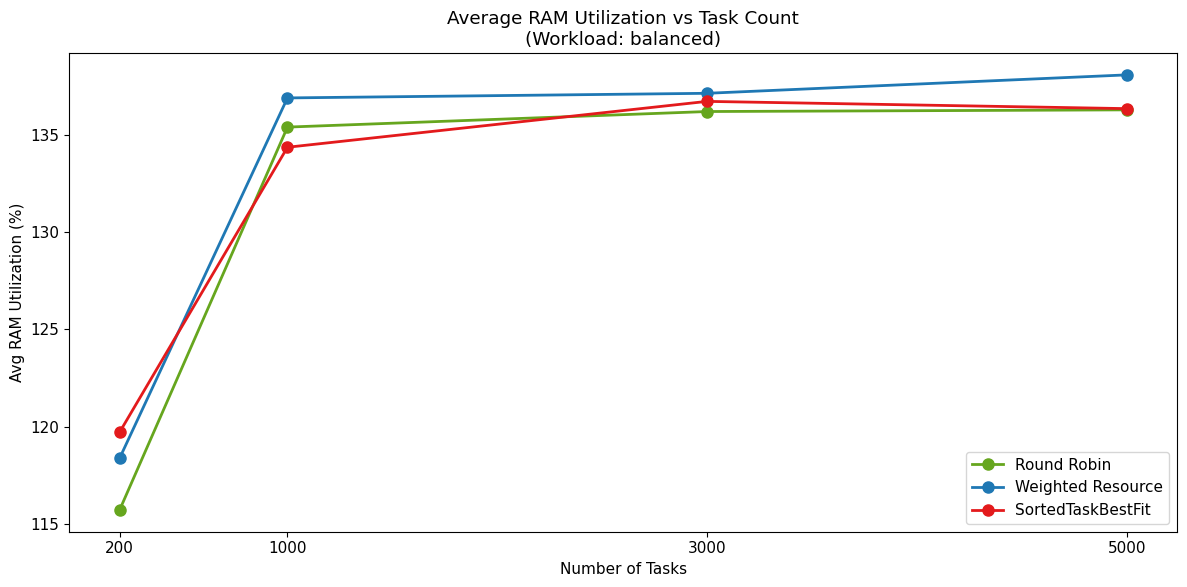

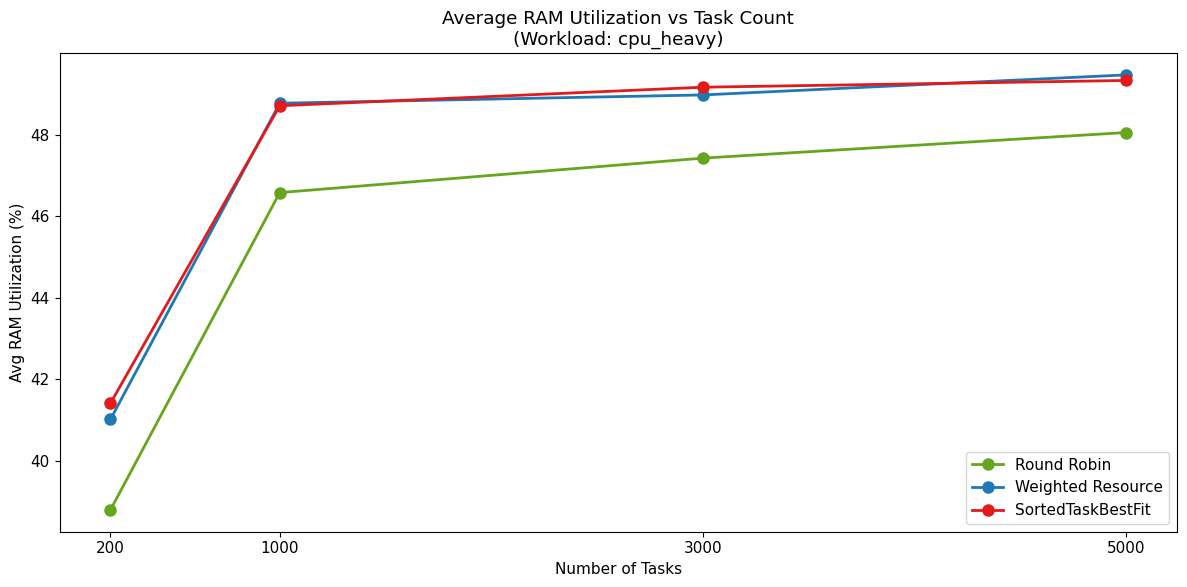

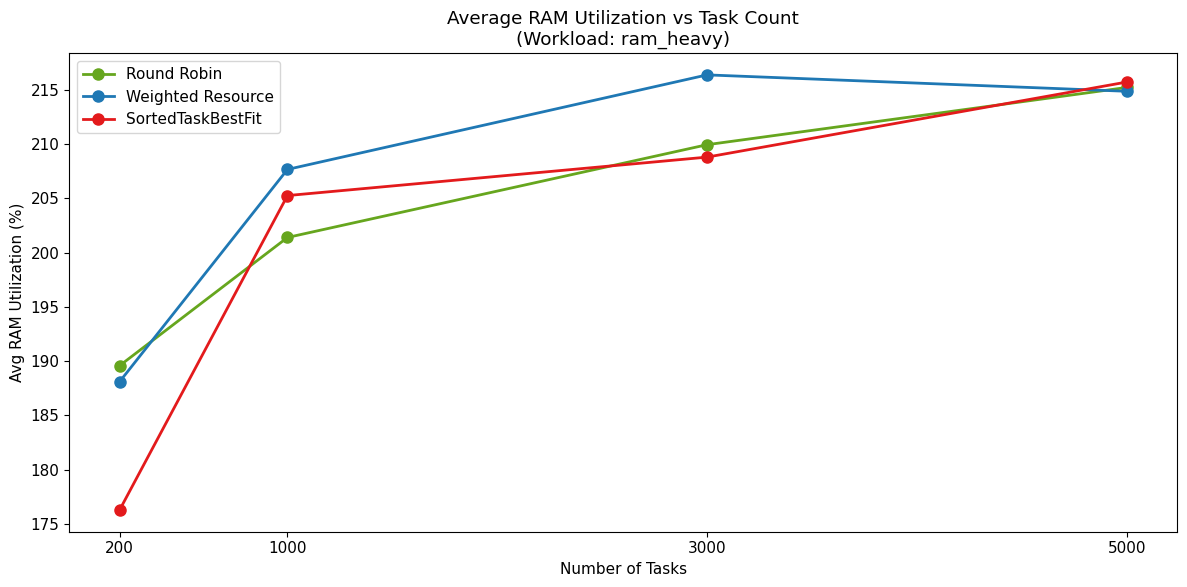

In [17]:
# Line chart - RAM vs task count per workload
for wt in workload_types:
    plot_line_by_task_count(df_machines, "avg_cluster_ram",
                            "Average RAM Utilization vs Task Count",
                            "Avg RAM Utilization (%)", workload_type=wt)
    plt.show()

## 5. Simulation Execution Time (Makespan) by Algorithm

Total time to complete all tasks - lower is better for throughput.

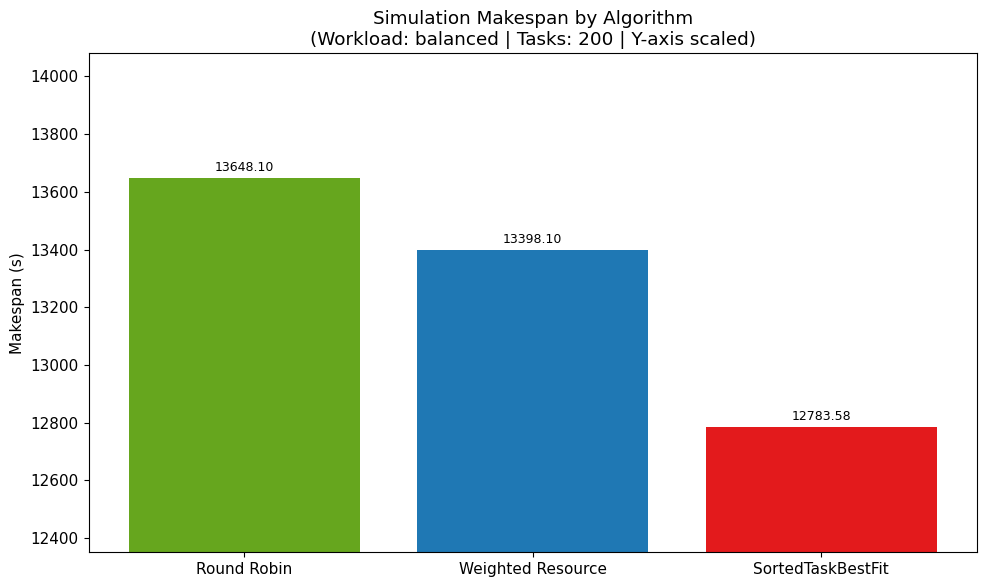

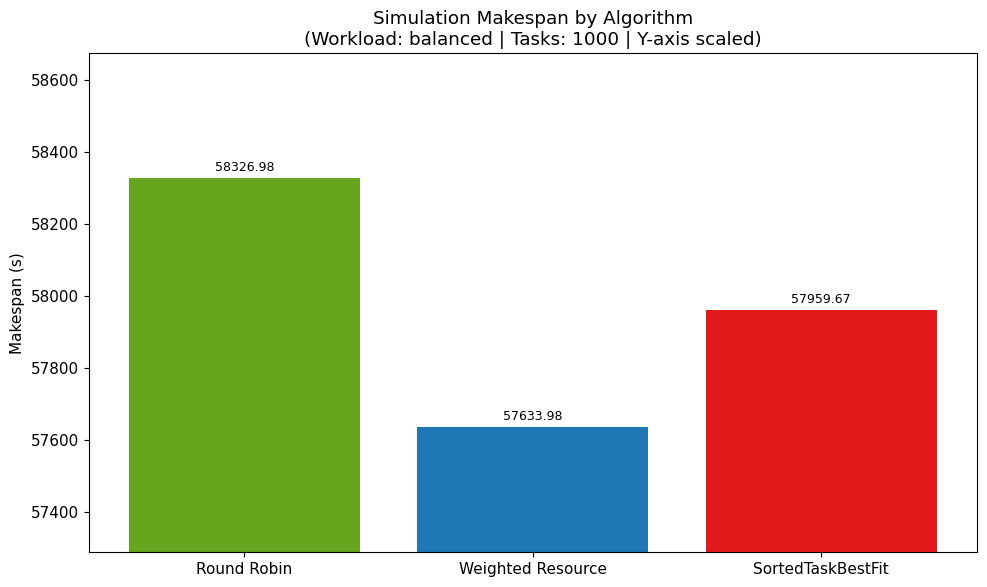

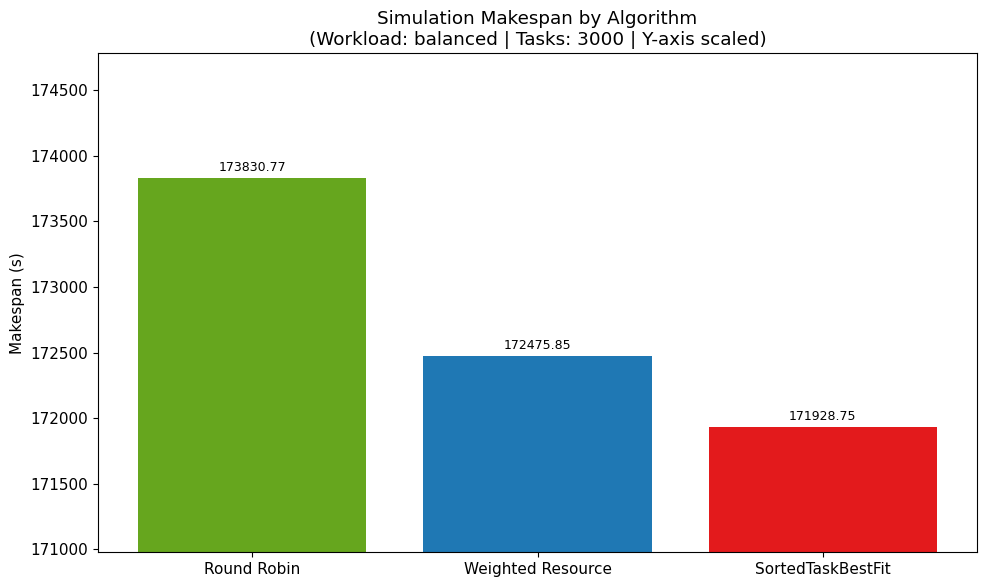

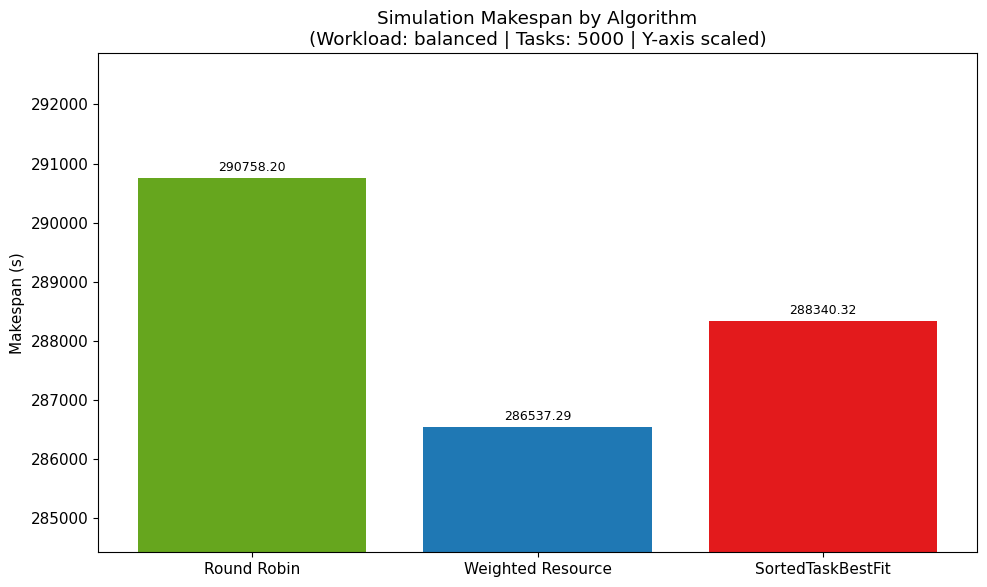

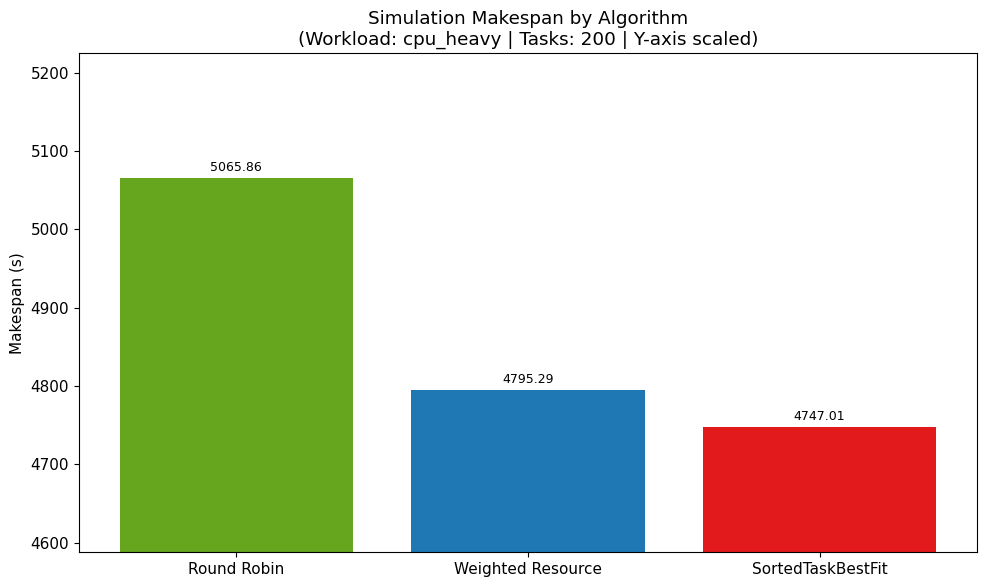

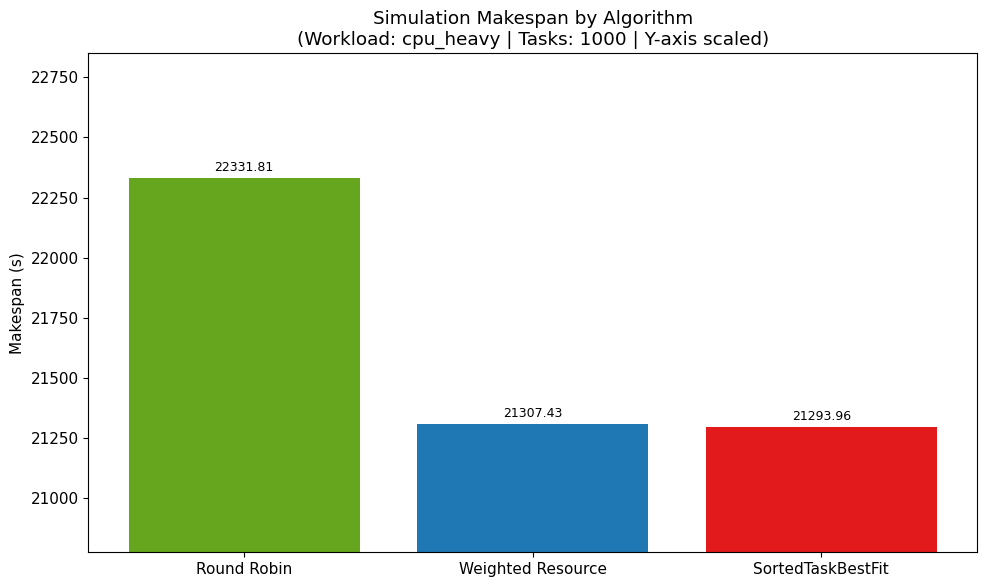

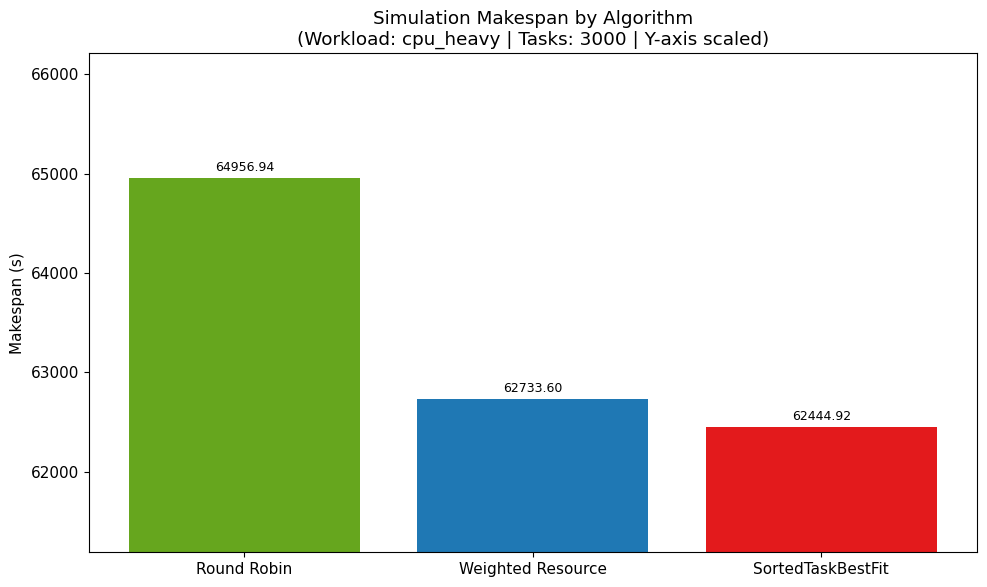

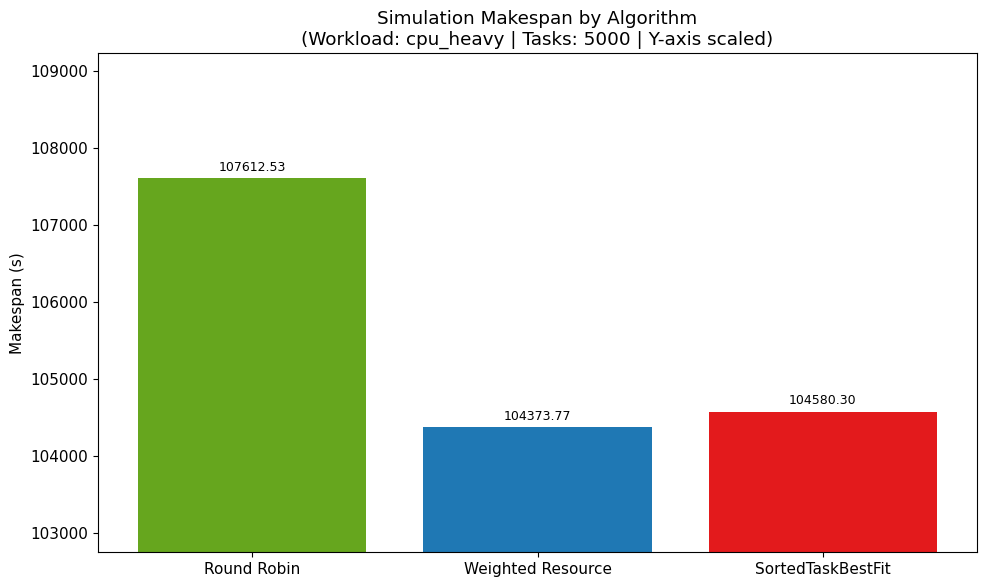

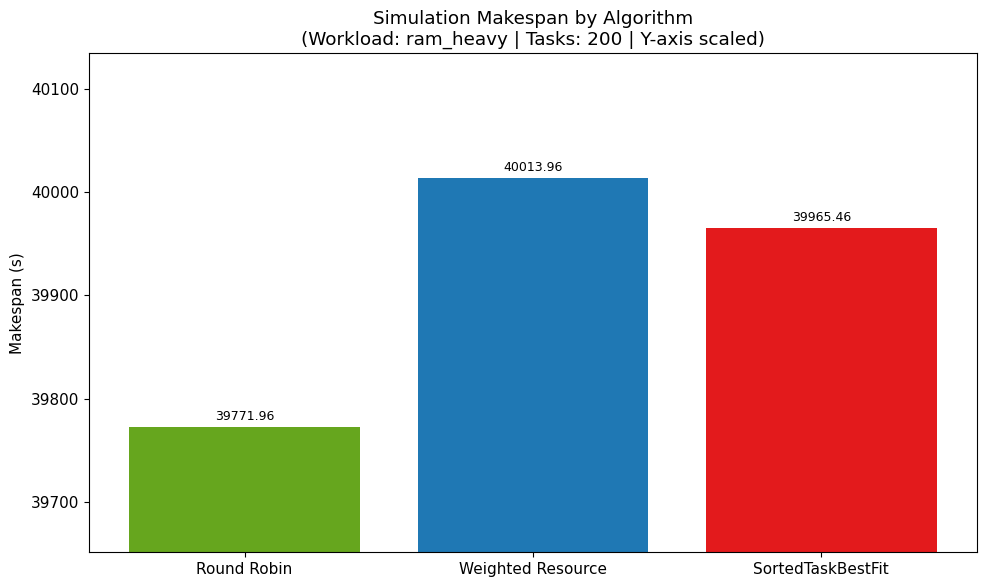

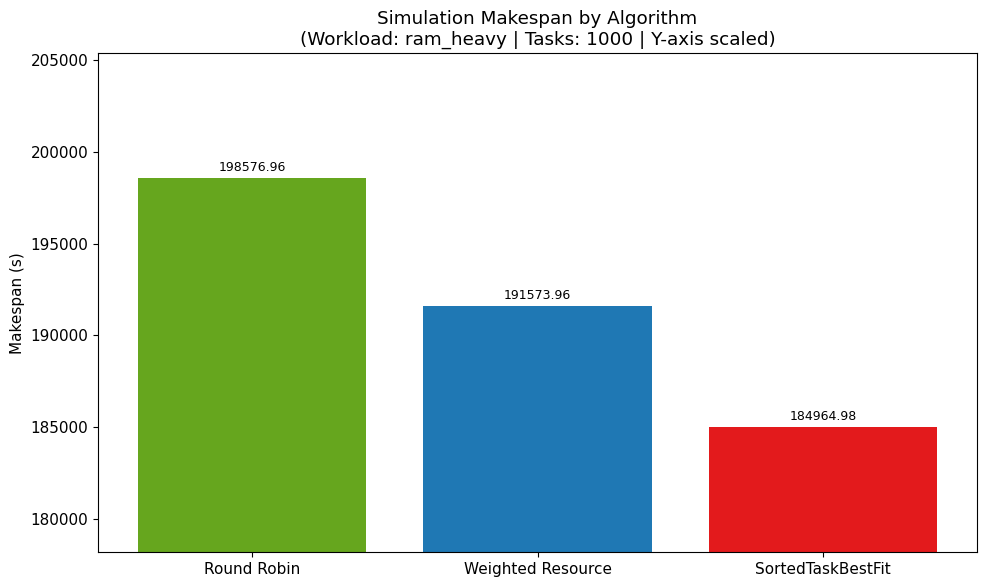

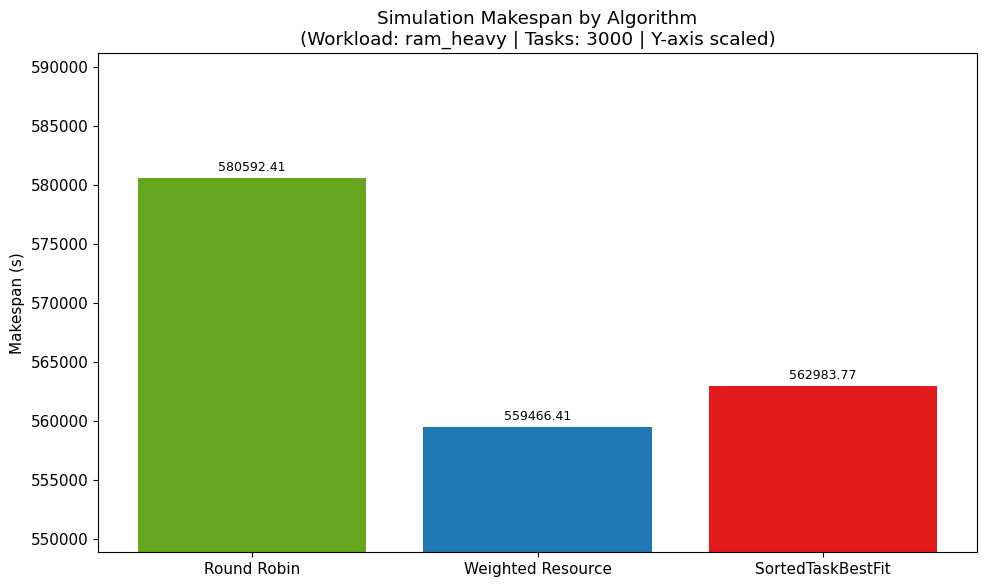

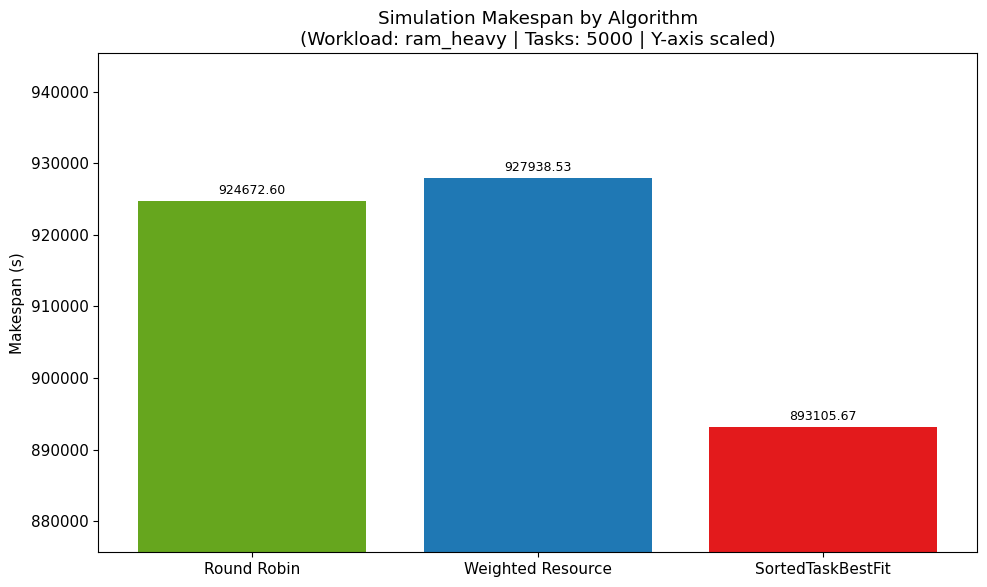

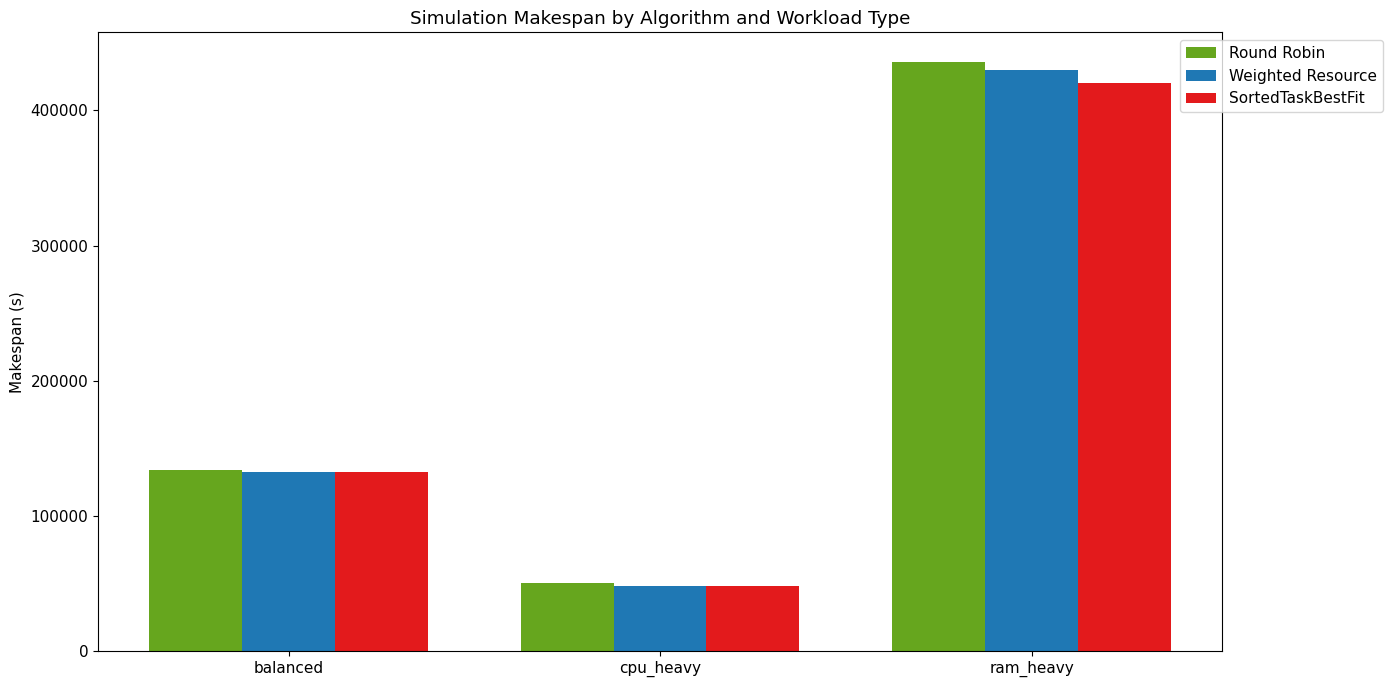

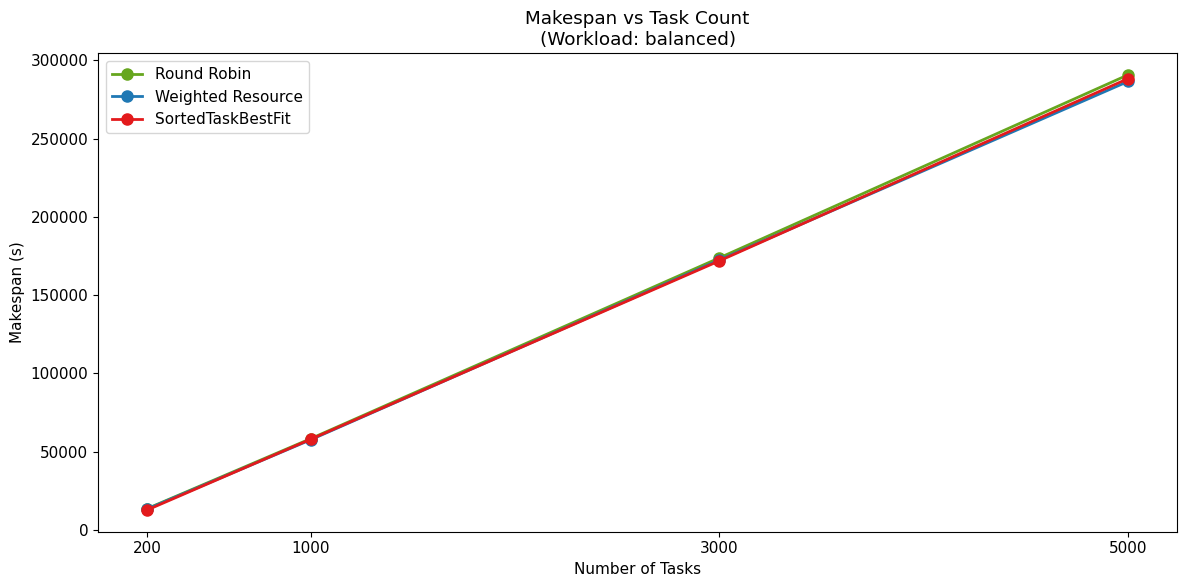

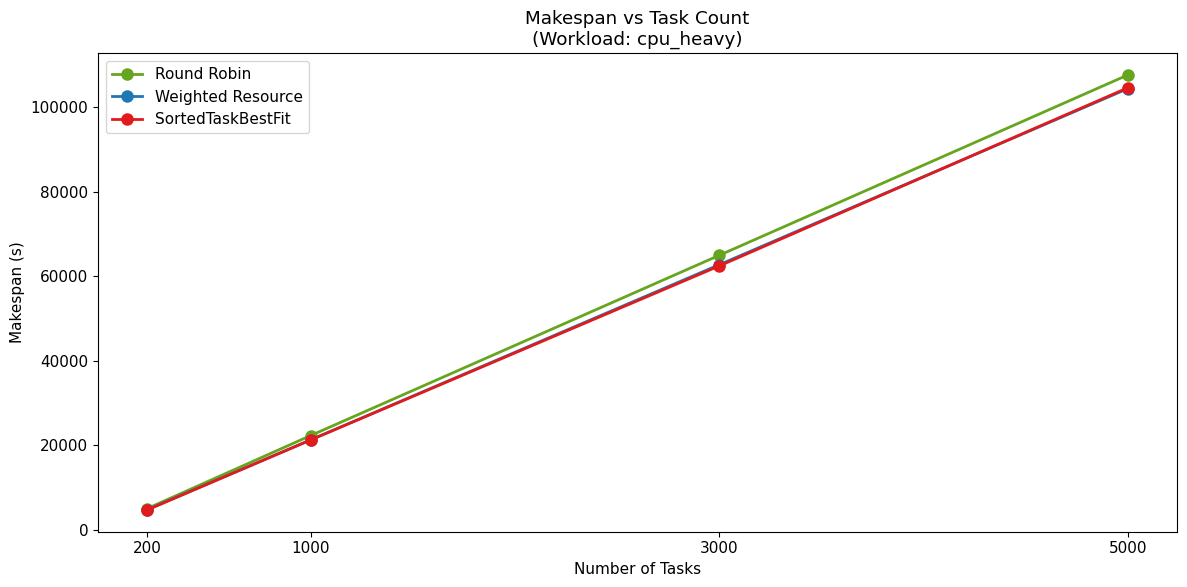

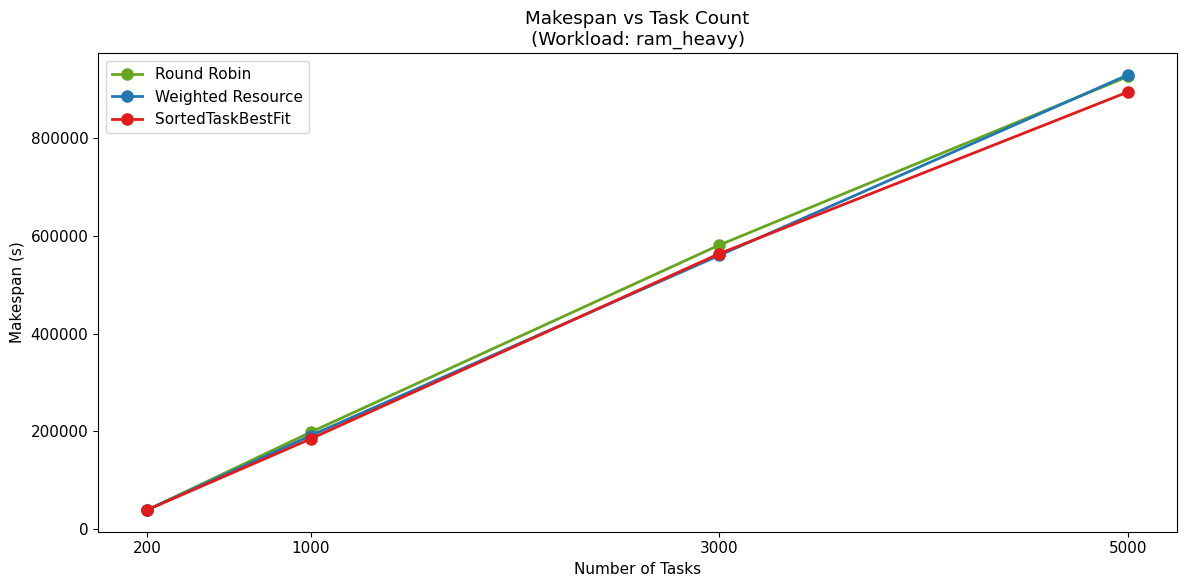

In [ ]:
# Makespan - Per workload type, per task count
for wt in workload_types:
    for tc in task_counts:
        plot_metric_comparison(df_tasks, "makespan", 
                               "Simulation Makespan by Algorithm",
                               "Makespan (s)", workload_type=wt, task_count=tc)
        plt.show()

# Grouped by workload type
plot_grouped_bars(df_tasks, "makespan", 
                  "Simulation Makespan by Algorithm and Workload Type",
                  "Makespan (s)", group_by="workload_type")
plt.show()

# Makespan scaling with task count
for wt in workload_types:
    plot_line_by_task_count(df_tasks, "makespan",
                            "Makespan vs Task Count",
                            "Makespan (s)", workload_type=wt)
    plt.show()